# Create Hosted Imagery Layer by transfering data from existing Cloud store to ArcGIS Online with ArcGIS Notebook

With ArcGIS Notebook Advance and ArcGIS API for Python, user can transfer their existing imagery data in the cloud store to ArcGIS Online and create Hosted Imagery Layer with ArcGIS Image for ArcGIS Online.  

- Identify the source cloud store from supported platform and create a cloud storage connection with the access credentials  
- Sign into ArcGIS Online org and acquire the SAS token for upload storage
- Transfer the imagery data from source cloud store to the ArcGIS Online upload storage 
- Create a tiled/dynamic imagery layer from the uploaded imagery data

The host of the cloud store is not important to the process, but each cloud store requires a cloud store connection to accesss the source storage. 
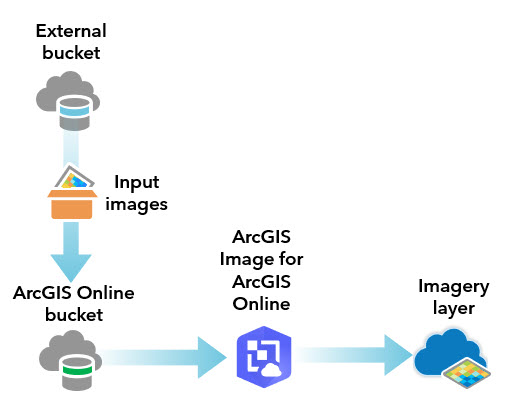

### Create a connection to an ArcGIS Online organization with ArcGIS Image 

In this section, you will create a connection to the ArcGIS Online organization that you will be using for the transfer and import the necessary modules to complete the process. 

In [1]:
import arcgis
from arcgis.raster.analytics import copy_raster
from arcgis.gis import GIS

arcgis.env.verbose=True

In [2]:
%%capture --no-display

# Connect to ArcGIS Online Organization as current log in user
gis = GIS("home")
gis

GIS @ https://www.arcgis.com version:2024.1

### Create Cloud Storage connection to the user's source storage

In this example, user has existing data in an Azure blob storage container. 
A cloud storage connection file (.acs) can be created with the access credentials from the user to prepare to transfer the imagery data to ArcGIS Online. 
A cloud storage connection file will be created in the temporary file system storage of ArcGIS Notebook and can be deleted after the data transfer has completed. 

#### An Advanced ArcGIS Notebook is required for this process since access to arcpy is only available with an advanced notebook. 

In [3]:
# Use "arcpy" API to create cloud storage connection. Note "arcpy" is only available with ArcGIS Notebook Advance
import arcpy


In [4]:
arcpy.env.overwriteOutput = 1

folder_name = "/arcgis/home"
src_connection_file = "userstore_azure.acs"
platform = "AZURE"
container_name = "<container name>"
account_name = "<account name>"
access_key = "<secret keys>"

source_connection = arcpy.management.CreateCloudStorageConnectionFile(
    out_folder_path=folder_name, 
    out_name=src_connection_file,
    service_provider="AZURE", 
    bucket_name=container_name, 
    access_key_id=account_name, 
    secret_access_key=access_key)


### Create Cloud Storage connection to ArcGIS Online's cloud storage

In order to create a hosted imagery layer, the imagery data needs to be transferred to user's ArcGIS Online's cloud storage. The following example shows how a user can also establish a cloud storage connection with ArcGIS Online's blob cloud storage through creating cloud storage connection file.

In [5]:
# Request direct access URL from ArcGIS Online org with the current log in ArcGIS Online user

from arcgis.raster.utils import *

access_url = arcgis.raster.utils.generate_direct_access_url(expiration=1440, gis=gis)
access_url

'https://stg-arcgisazureimagery.az.arcgis.com/gur1ywxnyloll4ys-a6db47a57d3af59beb9932d47b5b431e?sv=2018-03-28&sr=c&sig=p3g%2Fnh%2FB6da%2F3eaOSD5a3cmnLhXi23T7GjEpHBXlhcI%3D&st=2024-03-12T10%3A13%3A06Z&se=2024-03-13T10%3A18%3A06Z&sp=racwdl'

In [6]:
# Create cloud storage connection file with the information from the direct access URL

folder_name = "/arcgis/home"
target_connection_file = "agol_azure.acs"

account_name = "<account name>"
container_name = "<org id>-<user id>"

config_options = "AZURE_STORAGE_SAS_TOKEN <sas token>;CPL_AZURE_ENDPOINT <azure endpoint>"

source_connection = arcpy.management.CreateCloudStorageConnectionFile(
    out_folder_path=folder_name, 
    out_name=target_connection_file,
    service_provider="AZURE", 
    bucket_name=container_name, 
    access_key_id=account_name,
    config_options=config_options)

### Now Transfer the image data from user cloud storage to ArcGIS Online cloud storage

With the Transfer File tool, user can transfer the imagery data from its own cloud store to ArcGIS Online's cloud storage. 
The data transfer is happening through ArcGIS Notebook. Data is read from user's cloud storage, stream through Notebook server then upload to ArcGIS Online's cloud storage.  


In [7]:
import os

folder_name = "z:/arcgis/home"
src_connection_file = "userstore_azure.acs"
target_connection_file = "agol_azure.acs"
target_path = "/_images/Utah_USGS"

source = os.path.join(folder_name, src_connection_file) + "/Utah_USGS"
target = os.path.join(folder_name, target_connection_file) + target_path

arcpy.management.TransferFiles(source, target)

<Result ''>

## Create Hosted Imagery Layer from the data transferred to the ArcGIS Online cloud store

With user's data transferred to the ArcGIS Online cloud store, ArcGIS API for Python can be used to create the hosted imagery layer. Once the imagery data is in the ArcGIS Online cloud storage, it can be used like other input images to create imagery layers. 

In [8]:
# The following code snippet will convert the uploaded images to a single Tiled Imagery Layer
# by mosaicking multiple images

data_url = access_url.split('?')[0]+target_path
# https://stg-arcgisazureimagery.az.arcgis.com/gur1ywxnyloll4ys-a6db47a57d3af59beb9932d47b5b431e/_images/Utah_USGS

layer_name = "Utah_USGS_CS"

ImageryLayer = copy_raster(input_raster=data_url,
                           output_name=layer_name,
                           raster_type_name="Raster Dataset",
                           context={"buildFootprints": True,
                                    "footprintsArguments": {"method":"RADIOMETRY"},
                                    "buildOverview":True,
                                    "outSR":3857},
                           gis=gis)

Submitted.
Executing...
Start Time: Tuesday, March 12, 2024 3:17:08 PM
Raster Analytics helper service: https://rasteranalysis.arcgis.com/arcgis
Running on ArcGIS Online.
Read Data Store info from Registry.
Hosted Imagery Privilege Check: OK
Image service {'name': 'Utah_USGS_CS', 'serviceUrl': 'https://tiledimageservices.arcgis.com/gUR1YWXNyLOlL4Ys/arcgis/rest/services/Utah_USGS_CS/ImageServer'} already existed.
Output item id is: 71352aa8379f41d1ad4f1c64c54f8540
Output image service url is: https://tiledimageservices.arcgis.com/gUR1YWXNyLOlL4Ys/arcgis/rest/services/Utah_USGS_CS/ImageServer
Output cloud raster name is: Utah_USGS_CS
Input is a valid url https://stg-arcgisazureimagery.az.arcgis.com/gur1ywxnyloll4ys-a6db47a57d3af59beb9932d47b5b431e/_images/Utah_USGS
Input raster is: https://stg-arcgisazureimagery.az.arcgis.com/gur1ywxnyloll4ys-a6db47a57d3af59beb9932d47b5b431e/_images/Utah_USGS
Hosted data folder is: /cloudStores/gUR1YWXNyLOlL4Ys/71352aa8379f41d1ad4f1c64c54f8540
Finished c

<Item title:"Utah_USGS_CS" type:Imagery Layer owner:ndey618>
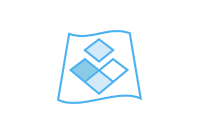

In [9]:
# Add the newly create Hosted Imagery Layer to the map, user has the option to create dynamimc imagery layer as well
# from uploaded images.

TiledImgLyr = gis.content.search(query=ImageryLayer.title, item_type='Imagery Layer')
TiledImgLyr[0]

In [10]:
# Add the Tiled Imagery Layer to Map

mapImgLyr = gis.map()
mapImgLyr.add_layer(TiledImgLyr[0])
mapImgLyr.zoom_to_layer(TiledImgLyr[0])
mapImgLyr

MapView(layout=Layout(height='400px', width='100%'))